In [25]:
# Import all required packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import xarray as xr
import numpy as np
from datetime import datetime, time, timedelta
import calendar
import random
import pprint

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5

import sys
sys.path.insert(0, "/home/raj/ocf/pv-solar-farm-forecasting/ukpn/load/gsp/")

from gsp_power_data_utils import *

%matplotlib inline

## UKPN Dashboard Data Report

[UKPN dashbaord](https://dsodashboard.ukpowernetworks.co.uk/d/jnTAkg7Gz/ukpn-dso-dashboard-grid-supply-areas?orgId=1&from=now-1y&to=now&refresh=10m&var-GSP=CANTERBURY%20NORTH) is provided by the organisation called "[UK Power Netowrks](https://www.ukpowernetworks.co.uk/)" through an open source analytics and monitroing interface called [Grafana](https://grafana.com/). It provides various metrics from the GSP such as Active Power Flow, Reactive Power Flow, Voltage , Frequency and Generator Outputs for all metered generation. For this data report, solar data generated from metered outputs has been considered. The data that can be manually downladable is in either csv or JSON format.

In [8]:
# Plotting a bar graph
folder_destination = "/home/raj/ocf/pv-solar-farm-forecasting/tests/data/ukpn_dashboard_data"
count_dict = get_gsp_data_in_dict(
    folder_destination = folder_destination,
    count_gsp_data = True)
# Printing the total number of GSP's
print(f"The total number of Solar data points in each GSP locaion is as follows")
pprint.pprint(count_dict)    

The total number of Solar data in    each GSP locaion is as follows
{'braintree': 160819,
 'burwell': 161114,
 'canterbury_north': 161763,
 'ninefield': 161942,
 'northfleet_east': 160720,
 'norwich': 161272,
 'rayleigh': 155842,
 'richborough': 54767,
 'sellindge': 161864}


All the GSP Power data has been downloaded manually from the [dashboard](https://dsodashboard.ukpowernetworks.co.uk/d/jnTAkg7Gz/ukpn-dso-dashboard-grid-supply-areas?orgId=1&from=now-1y&to=now&refresh=10m&var-GSP=CANTERBURY%20NORTH), but it will be automated as we move forward. The frequency of the data is 10Min, GSP's has different starting dates in their historic data, but it is live data, meaning the data downloaded will be upto the last 10th minute in the current hour.

In [19]:
# Getting the starting dates of each GSP data
data_dict = get_gsp_data_in_dict(folder_destination = folder_destination)
starting_dates = {}
for gsp_name, data_frame in  data_dict.items():
    starting_dates[gsp_name] = data_frame.first_valid_index().strftime("%Y-%m-%d")
print("The GSP Solar Data starting dates in their csv files are as follows:")
pprint.pprint(starting_dates)
print("\nMost of the data has similar starting dates, and below are the common starting dates")
print(set(list(starting_dates.values())))

The GSP Solar Data starting dates in their csv files are as follows:
{'braintree': '2019-12-23',
 'burwell': '2019-12-23',
 'canterbury_north': '2019-12-16',
 'ninefield': '2019-12-16',
 'northfleet_east': '2019-12-23',
 'norwich': '2019-12-23',
 'rayleigh': '2019-12-23',
 'richborough': '2021-12-30',
 'sellindge': '2019-12-16'}

Most of the data has similar starting dates, and below are the common starting dates
{'2019-12-16', '2019-12-23', '2021-12-30'}


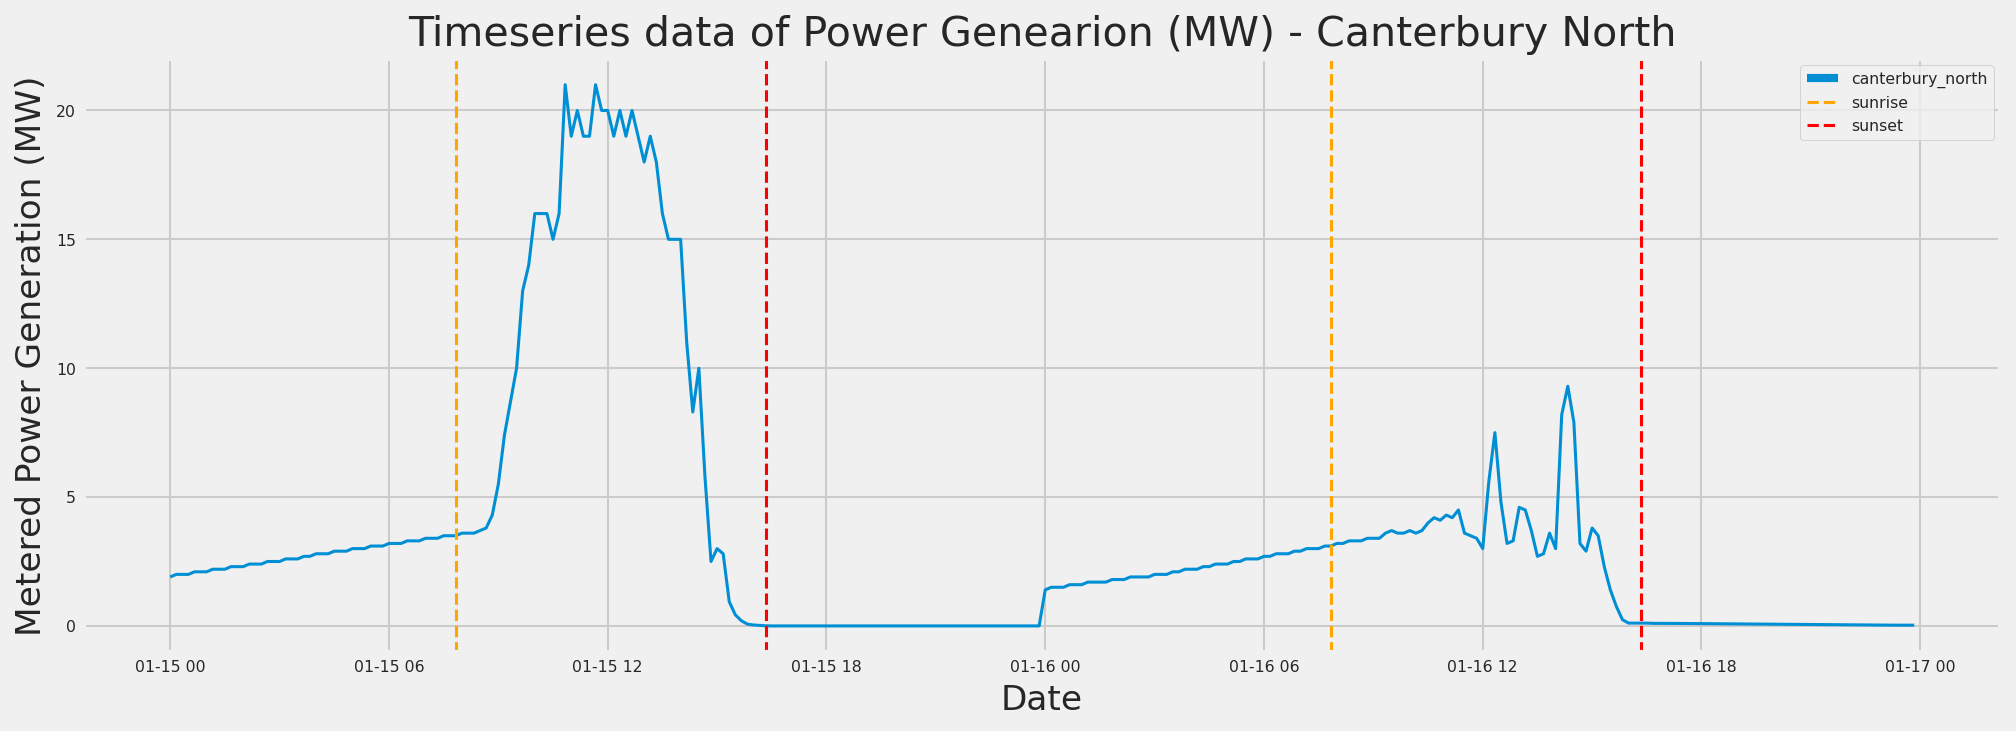

In [26]:
# Plotting Canterbury Metered power generation for the current month (18/01/2023)

# Loading the file
path_to_file = Path("/home/raj/ocf/pv-solar-farm-forecasting/tests/data/ukpn_dashboard_data/canterbury_north.csv")
canterbury_df = load_csv_to_pandas(path_to_file = path_to_file)

# Getting the 2023 Jan data
canterbury_df_jan = canterbury_df[canterbury_df.index.year == 2023]
canterbury_df_jan = canterbury_df_jan[np.in1d(canterbury_df_jan.index.day.values, [15,16,17])]

# Sunrise and Sunset time
sunrise_time = time(7, 50)
sunrise_time = canterbury_df_jan[np.in1d(canterbury_df_jan.index.time, sunrise_time)].index.values
sunset_time = time(16,20)
sunset_time = canterbury_df_jan[np.in1d(canterbury_df_jan.index.time, sunset_time)].index.values

def legend_without_duplicate_labels(figure):
    """Prevents legend labels from duplicating
    link - https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib
    """
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    figure.legend(by_label.values(), by_label.keys(), loc='upper right')

# Plotting
sns.lineplot(data = canterbury_df_jan, linewidth = 1.5)
for i in range(len(sunrise_time)):
    plt.axvline(sunrise_time[i], linewidth = 1.5, color = 'orange', linestyle = '--', label = 'sunrise')
    plt.axvline(sunset_time[i], linewidth = 1.5, color = 'red', linestyle = '--', label = 'sunset')
    # Naming legend
    legend_without_duplicate_labels(plt)
    plt.title("Timeseries data of Power Genearion (MW) - Canterbury North")
    plt.xlabel("Date")
    plt.ylabel("Metered Power Generation (MW)")


In [ ]:
# Classification of power generated by seasons

# Loading the file
path_to_file = "/home/raj/ocf/pv-solar-farm-forecasting/tests/data/ukpn_dashboard_data/canterbury_north.csv"
canterbury_df = load_csv_to_pandas(path_to_file = path_to_file)

# Resetting the index
canterbury_df.reset_index(inplace=True)

# Defining Seasons
seasons = {
    1 : "Winter",
    2 : "Winter",
    3 : "Spring",
    4 : "Spring",
    5 : "Spring",
    6 : "Summer",
    7 : "Summer",
    8 : "Summer",
    9 : "Autumn",
    10 : "Autumn",
    11 : "Autumn",
    12 : "Winter"
}
# Getting the data for only 2022
canterbury_df_2022 = canterbury_df[canterbury_df["date_time"].dt.year == 2022].reset_index(drop=True)

# Getting the data for the mid-day 11am to 1pm
canterbury_df_2022 = canterbury_df_2022.set_index("date_time")
canterbury_df_2022  = canterbury_df_2022.between_time('11:00', '13:00')

# Getting the average for a single day
canterbury_avg_2022 = canterbury_df_2022.groupby([
    canterbury_df_2022.index.month, canterbury_df_2022.index.day])["canterbury_north"].mean().to_frame()

# Getting the seasons of the year
canterbury_avg_2022.index.set_names(['month' , 'date'], inplace = True)
canterbury_avg_2022.reset_index(inplace = True)
canterbury_avg_2022["season"] = canterbury_avg_2022["month"].apply(lambda month_number: seasons[month_number])
canterbury_avg_2022["month"] = canterbury_avg_2022["month"].apply(lambda month_number: calendar.month_abbr[month_number])

# Plot the data
# This plot classifies the average power generated on every mid-day (11am - 1pm) of a season day
# For example, the first bar represents the average of 1st day of every month in a season
ax = sns.barplot(data = canterbury_avg_2022, x = 'date', y = 'canterbury_north', hue = "season", ci = None)
ax.set_xlabel('Typical days of a month', fontsize = 10)
ax.set_ylabel('Average Power Generated (MW)', fontsize = 10)
ax.axes.set_title("Mid-day avg power(MW) generated in 2022 - Canterbury North", fontsize = 12)
plt.show


In [ ]:
# Interpolating the negative values in the data frame

# Loading the file
path_to_file = "/home/raj/ocf/pv-solar-farm-forecasting/tests/data/ukpn_dashboard_data/canterbury_north.csv"
canterbury_df = load_csv_to_pandas(path_to_file = path_to_file)


# Getting the indices of the negative values
canterbury_negative_indices = check_for_negative_data(original_df = canterbury_df)
unique_dates_with_negative = canterbury_negative_indices.map(lambda t: t.date()).unique()

# Converting the dates to list
select_dates = random.sample(unique_dates_with_negative.to_list(), 1)

# Getting the required dataframe
final_dataframe = pd.DataFrame([])

for i in range(len(select_dates)):
    # Filtering dataframe based on each date with negative values
    originL_df = canterbury_df.loc[pd.to_datetime(canterbury_df.index.values).date == select_dates[i]]
    filter_df = check_for_negative_data(original_df = originL_df, replace_with_nan = True)

    # Interpolating the missing values
    start_date = select_dates[i].strftime("%Y-%m-%d")
    end_date = (datetime.strptime(start_date, "%Y-%m-%d") + timedelta(days = 1)).strftime("%Y-%m-%d")
    interpolated_df = interpolation_pandas(
        original_df = filter_df, 
        start_date = start_date,
        end_date = end_date,
        freq = "10Min",
        drop_last_row = True)
    
    # Dropping the duplicates
    interpolated_df = interpolated_df[~interpolated_df.index.duplicated(keep = 'first')]
    print(interpolated_df[interpolated_df.columns[0]].values)
    # Concating with the final dataframe
    final_dataframe = pd.concat([final_dataframe, interpolated_df])



In [ ]:
def first_plot(
    path_to_file: str
    ):
    # Getting the original data frame
    original_df = load_csv_to_pandas(path_to_file=path_to_file)

    # Getting the slopes of every two rows for the entire data frame column
    original_df["slope"] = original_df["test"].rolling(window = 2).apply(lambda x: x[1]-x[0])
    original_df["slope"] = original_df["slope"].fillna(0)

    # Getting the dates of the days with slopes range 
    active_timestamps = original_df[~original_df["slope"].between(-1.5, 1.5)]

    # Getting the most common times of the data with active power
    active_timestamps = active_timestamps.index.time
    print(np.unique(active_timestamps))
    

    # derivative = original_df[original_df.columns[0]].diff() / original_df.index.to_series().diff().dt.total_seconds()
    # original_df["trend"] = derivative.gt(0).map({False : '-1', True : '1'})
    # print(original_df.head(20))
    original_df = original_df.head(144)
    original_df.plot(y="test", use_index=True)
    plt.xlabel("Date Range")
    plt.ylabel("Gnenerated metered power (MW)")
    plt.title("Time series data of power generated")
    plt.show()
